# Exploratory Data Analysis (EDA) of NYC Metro Database

## Table of Contents:
* [1. Imports](#imports)
* [2. Exploring the dataset](#exploring-dataset)
    * [2.1. Cleaning and transforming data](#cleaning-data)
    * [2.2. Removing outliers](#removing-outliers)
    * [2.3. Vizualizations](#vizualizations)
* [3. Generating datasets for forecasting](#generating-datasets)
    * [3.1. Preprocessing and saving files](#preprocessing-saving)
* [4. Analyzing time series](#analyzing-time-series)
    * [4.1. Check stationarity with Dickey-Fuller test](#check-stationarity)
* [5. Final considerations](#final-considerations)

# 1. Imports <a class="anchor" id="imports"></a>

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

import warnings
warnings.filterwarnings('ignore')

In [2]:
# GLOBAL VARIABLES
DATASET_FOLDER = 'dataset'
CSV_FILE = '2015.csv'

# 2. Exploring the dataset <a class="anchor" id="exploring-dataset"></a>

Let's take a look at our data.

In [3]:
df = pd.read_csv(os.path.join(DATASET_FOLDER, CSV_FILE))
df.describe(include=np.object)

,time,ca,unit,scp,station,linename,division,desc
count,10055314,10055314,10055314,10055314,10055314,10055314,10055314,10055314
unique,611470,731,467,219,567,112,6,2
top,2015-09-15 16:00:00,PTH08,R549,00-00-00,34 ST-PENN STA,1,IRT,REGULAR
freq,2398,55280,130452,1008292,223818,1166199,3679948,10016146


In [4]:
df.sample(10)

,time,ca,unit,scp,station,linename,division,desc,entries,exits
2760082,2015-04-11 00:00:00,R147,R033,04-00-05,42 ST-TIMES SQ,1237ACENQRS,IRT,REGULAR,9695480.0,3846953.0
5015129,2015-07-02 05:00:00,N114,R297,01-00-02,FRANKLIN AVE,ACS,IND,REGULAR,804650.0,1141471.0
7386196,2015-09-26 08:00:00,R250,R179,00-00-06,86 ST,456,IRT,REGULAR,18237824.0,1744430.0
1315887,2015-02-17 09:00:00,N329,R201,00-03-04,WOODHAVEN BLVD,MR,IND,REGULAR,1381680.0,1851750.0
3165823,2015-04-25 20:00:00,R311,R053,00-05-00,149 ST-3 AVE,25,IRT,REGULAR,356.0,0.0
2070659,2015-03-16 20:00:00,R174,R034,00-00-01,125 ST,1,IRT,REGULAR,3002064.0,3674556.0
5696762,2015-07-27 04:00:00,A071,R044,02-00-00,CHAMBERS ST,JZ456,BMT,REGULAR,54792.0,23950.0
5576426,2015-07-22 17:00:00,N310,R140,01-06-00,QUEENS PLAZA,EMR,IND,REGULAR,2228427.0,2497164.0
7193360,2015-09-19 09:00:00,R219,R160,00-00-02,ASTOR PLACE,6,IRT,REGULAR,14609190.0,1621421.0
6402239,2015-08-21 17:00:00,R231,R176,00-00-05,33 ST,6,IRT,REGULAR,8043942.0,2904234.0


In summary we have:

* **time**: represents the date and time of each data acquisition.
* **ca/unit/scp**: different turnstile identifiers which combined give us a unique turnstile ID.
* **station**: name of the station in which the turnstile is located.
* **linename**: name of the subway line linked to a given turnstile.
* **division**: macro regions composed by multiple stations and lines.
* **desc**: provides information about the audit event. We focused on REGULAR events, which represents data colleted at each 4 hours.
* **entres/exits**: cumulative entry and exit register values for a given turnstile.

## 2.1. Cleaning and transforming Data <a class="anchor" id="cleaning-data"></a>

First of all it's important to clean our data.

In [5]:
# Check how many null value is on the dataset
df.isna().sum()

time        0
ca          0
unit        0
scp         0
station     0
linename    0
division    0
desc        0
entries     0
exits       0
dtype: int64

In [6]:
# Drop rows with null values
df = df.dropna()

# Drop non regular rows
df = df[df.desc == "REGULAR"]

# Combine the columns 'ca', 'unit' and 'scp' into a new one called 'turnstile'
df['turnstile'] = df['ca'] + '-' + df['unit'] + '-' + df['scp']

# Create a separate columns for date and time
df['datetime'] = pd.to_datetime(df.time)

# Drop duplicates
df.drop_duplicates(subset=['division', 'station', 'linename', 'turnstile', 'datetime'], keep='first', inplace=True)

# Drop Columns
df.drop(['ca', 'unit', 'scp', 'division', 'time', 'desc'], axis=1, inplace=True)

# Ensure rows are sorted by time
df = df.sort_values(['station', 'turnstile', 'datetime']).reset_index()

The Turnstile entries/exits seems to be a cumulative sum of the occurrences. So, we need to calculate the diff value between turnstile reads.

In [7]:
df_turnstile_group = df.groupby('turnstile')

df['diff_entries'] = df_turnstile_group['entries'].diff().fillna(0)
df['diff_exits'] = df_turnstile_group['exits'].diff().fillna(0)

df.head()

,index,station,linename,entries,exits,turnstile,datetime,diff_entries,diff_exits
0,9900134,1 AV,L,10536080.0,11482385.0,H007-R248-00-00-00,2015-12-26 08:00:00,0.0,0.0
1,9904668,1 AV,L,10536102.0,11482504.0,H007-R248-00-00-00,2015-12-26 12:00:00,22.0,119.0
2,9909222,1 AV,L,10536377.0,11482929.0,H007-R248-00-00-00,2015-12-26 16:00:00,275.0,425.0
3,9913776,1 AV,L,10536886.0,11483458.0,H007-R248-00-00-00,2015-12-26 20:00:00,509.0,529.0
4,9918322,1 AV,L,10537404.0,11484131.0,H007-R248-00-00-00,2015-12-27 00:00:00,518.0,673.0


Checking diff_entries and diff_exits values

       diff_entries    diff_exits
count  1.001615e+07  1.001615e+07
mean   4.156858e+03  3.241724e+03
std    3.784678e+06  3.229032e+06
min   -2.022943e+09 -2.080392e+09
25%    1.100000e+01  9.000000e+00
50%    7.900000e+01  5.400000e+01
75%    2.510000e+02  1.690000e+02
max    2.025053e+09  2.088518e+09


<AxesSubplot:xlabel='diff_exits', ylabel='Density'>

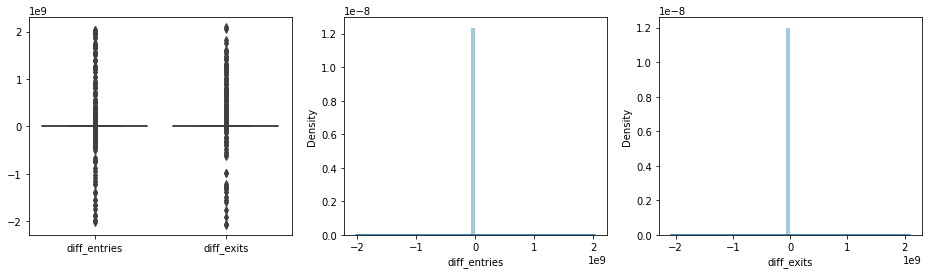

In [8]:
print(df[['diff_entries', 'diff_exits']].describe())

fig, ax = plt.subplots(1, 3, figsize=(16, 4))
sns.boxplot(data=df.loc[:, ['diff_entries', 'diff_exits']], ax=ax[0])
sns.distplot(df.diff_entries, ax=ax[1])
sns.distplot(df.diff_exits, ax=ax[2])

As we can see above this columns have a lot of outliers.

Bearing in mind that we are analyzing events from individual turnstiles over a period of 4 hours, we can imagine an unlikely scenario where we have one person/second crossing the turnstiles. In this case we will have 14,400 (4h * 60m * 60s) entries or exits.

However, our data have negative and very large values (>> 14400) which doesn't make sense.

## 2.2. Removing outliers <a class="anchor" id="removing-outliers"></a>

Let's replace spurious values with the median value of the series.

In [9]:
for key in ["diff_entries", "diff_exits"]:
    median_value = df[key].median()
    df[key][df[key] < 0] = median_value
    df[key][df[key] > df[key].quantile(0.99)] = median_value

       diff_entries    diff_exits
count  1.001615e+07  1.001615e+07
mean   1.686543e+02  1.256558e+02
std    2.231041e+02  1.823321e+02
min    0.000000e+00  0.000000e+00
25%    1.200000e+01  9.000000e+00
50%    7.900000e+01  5.400000e+01
75%    2.400000e+02  1.610000e+02
max    1.259000e+03  1.146000e+03


<AxesSubplot:xlabel='diff_exits', ylabel='Density'>

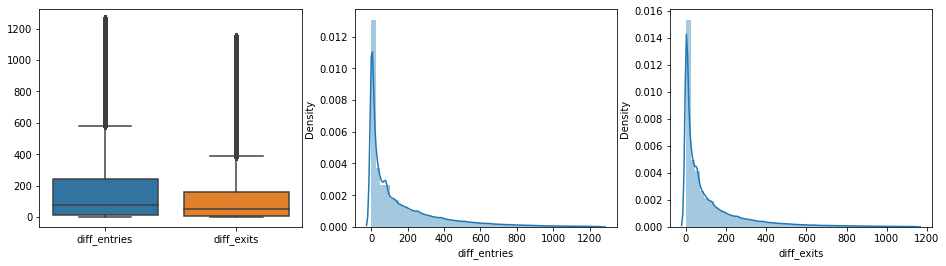

In [10]:
print(df[['diff_entries', 'diff_exits']].describe())

fig, ax = plt.subplots(1, 3, figsize=(16, 4))
sns.boxplot(data=df.loc[:, ['diff_entries', 'diff_exits']], ax=ax[0])
sns.distplot(df.diff_entries, ax=ax[1])
sns.distplot(df.diff_exits, ax=ax[2])

After removing some outliers our plots looks better now.

#### Combining features

As a final transformation I will combine the entries and exits into a new variable called Traffic

In [11]:
df['traffic'] = df['diff_entries'] + df['diff_exits']

## 2.3. Vizualizations <a class="anchor" id="vizualizations"></a>

After cleaning our the data, we can take a look at more generic views considering all the turnstiles.

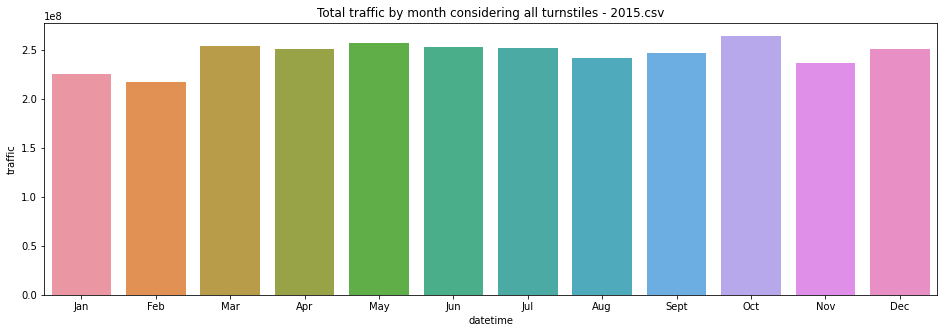

In [12]:
df_total_by_month = df.groupby(df.datetime.dt.month)[['traffic']].sum().reset_index()

plt.figure(figsize=(16, 5))
ax = sns.barplot(
    data=df_total_by_month,
    x='datetime',
    y='traffic',
)
_ = ax.set(title=f"Total traffic by month considering all turnstiles - {CSV_FILE}")
_ = ax.set_xticks(range(12), ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sept", "Oct", "Nov", "Dec"])
del df_total_by_month

Looking at the figure above, we can see that January and February were the months with the lowest traffic. However, the months of the year have very similar traffic, so we don't have any kind of seasonality at this level.

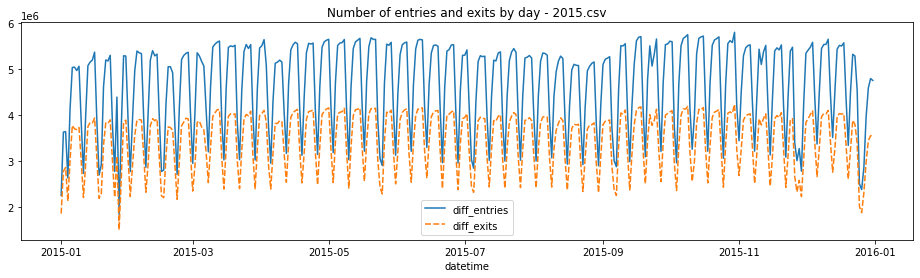

In [13]:
# Plot entries and exits over time
resample_day = df.resample('D', on='datetime')
df_total_by_day = resample_day[['diff_entries', 'diff_exits']].sum()

plt.figure(figsize=(16, 4))
sns.lineplot(data=df_total_by_day).set(title=f"Number of entries and exits by day - {CSV_FILE}")
del resample_day, df_total_by_day

When we look at the traffic by day we can note that there is a very obvious seasonality at the week traffic.

So, let's plot the traffic by day of the week.

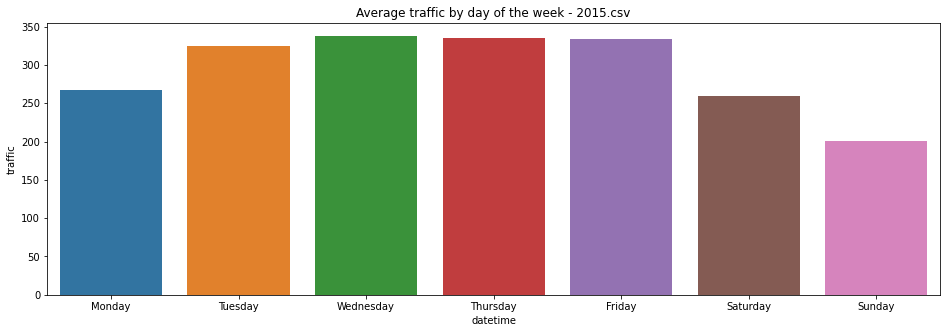

In [14]:
df_total_by_day_of_week = df.groupby(df.datetime.dt.day_of_week)[['traffic']].mean().reset_index()

plt.figure(figsize=(16, 5))
ax = sns.barplot(
    data=df_total_by_day_of_week,
    x='datetime',
    y='traffic',
)
_ = ax.set(title=f"Average traffic by day of the week - {CSV_FILE}")
_ = ax.set_xticks(range(7), ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
del df_total_by_day_of_week

Sundays have the lowest traffic and weekdays have a more intensive traffic.

This pattern seems to repeat itself in practically every week, which implies that we have a weekly seasonality.

In [15]:
del df

# 3. Generating datasets for forecasting <a class="anchor" id="generating-datasets"></a>

Now that we have an idea of how our data behaves, let's prepare it for forecast.

In [16]:
CSV_FILES = ['20%d.csv' % (year) for year in list(range(10, 18))]

## 3.1. Preprocessing and saving files <a class="anchor" id="preprocessing-saving"></a>

Apply the same preprocessing operations as in the investigation above.

In [17]:
def preprocessing(df):
    """
    Filter and transform the dataframe.
    """
    # Drop rows with null values
    df = df.dropna()

    # Drop non regular rows
    df = df[df.desc == "REGULAR"]

    # Combine the columns 'ca', 'unit' and 'scp' into a new one called 'turnstile'
    df['turnstile'] = df['ca'] + '-' + df['unit'] + '-' + df['scp']

    # Create a separate columns for date and time
    df['datetime'] = pd.to_datetime(df.time)

    # Drop duplicates
    df.drop_duplicates(subset=['station', 'linename', 'turnstile', 'datetime'], keep='first', inplace=True)

    # Ensure rows are sorted by time
    df = df.sort_values(['station', 'turnstile', 'datetime']).reset_index()
        
    # Calculate diff entries and exits
    df_turnstile_group = df.groupby('turnstile')
    df['diff_entries'] = df_turnstile_group['entries'].diff().fillna(0)
    df['diff_exits'] = df_turnstile_group['exits'].diff().fillna(0)
    
    # Remove outliers
    for key in ["diff_entries", "diff_exits"]:
        median_value = df[key].median()
        df[key][df[key] < 0] = median_value
        df[key][df[key] > df[key].quantile(0.99)] = median_value
    
    # Combine entries and exits into a new variable called traffic
    df['traffic'] = df['diff_entries'] + df['diff_exits']
    
    # Group traffic by station and linename
    df_station = df.groupby(['station', df.datetime.dt.to_period('D')]).traffic.sum().reset_index()
    df_line = df.groupby(['linename', df.datetime.dt.to_period('D')]).traffic.sum().reset_index()
    
    return df_station, df_line

The csv files are relatively large and may not fit in memory, so processing must be done in chunks. After process our data we will save it using the *parquet* binary format.

In [18]:
st_filepath = os.path.join(DATASET_FOLDER, 'daily_traffic_by_station.parquet')
ln_filepath = os.path.join(DATASET_FOLDER, 'daily_traffic_by_line.parquet')

if not os.path.exists(st_filepath) or not os.path.exists(ln_filepath):
    chunksize = 3 * 10 ** 6

    df_st = pd.DataFrame()
    df_ln = pd.DataFrame()

    # Processing all CSV FILES. Obs: This operation can take a few minutes.
    for csv_file in CSV_FILES:
        print("Processing:", csv_file)

        for df_chunk in pd.read_csv(os.path.join(DATASET_FOLDER, csv_file), chunksize=chunksize):
            df_st_c, df_ln_c = preprocessing(df_chunk)
            df_st = pd.concat((df_st, df_st_c))
            df_ln = pd.concat((df_ln, df_ln_c))

    # Sort dataframes and remove duplicates
    df_st.drop_duplicates(subset=['station', 'datetime'], keep='first', inplace=True)
    df_st = df_st.sort_values(['station', 'datetime'])[2:-1]
    df_st.datetime = df_st.datetime.astype('str').astype('datetime64')
    
    df_ln.drop_duplicates(subset=['linename', 'datetime'], keep='first', inplace=True)
    df_ln = df_ln.sort_values(['linename', 'datetime'])[2:-1]
    df_ln.datetime = df_ln.datetime.astype('str').astype('datetime64')

    # Save them
    df_st.to_parquet(st_filepath, index=False)
    df_ln.to_parquet(ln_filepath, index=False)
    
    del df_st, df_ln

# 4. Analyzing time series <a class="anchor" id="analyzing-time-series"></a>

Loading the datasets

In [19]:
# Dataframe with traffic by station and day
df_st = pd.read_parquet(os.path.join(DATASET_FOLDER, 'daily_traffic_by_station.parquet'))

# Dataframe with traffic by linename and day
df_ln = pd.read_parquet(os.path.join(DATASET_FOLDER, 'daily_traffic_by_line.parquet'))

# Dataframe with the total traffic by day
df_tot = df_ln.groupby('datetime').traffic.sum().reset_index()

In [20]:
df_st.sample(5)

,station,datetime,traffic
841292,PACIFIC ST,2013-01-29,25157.0
47543,14 ST-UNION SQ,2014-09-13,137733.0
160999,28 ST,2017-02-05,39142.0
94010,176 ST,2012-08-30,8048.0
532140,DELANCEY/ESSEX,2016-10-21,48774.0


## 4.1. Check stationarity with Dickey-Fuller test <a class="anchor" id="check-stationarity"></a>

In [21]:
def dickey_fuller_test(x, print_results=True):
    result = adfuller(x)
    if print_results:
        print('ADF Statistic: %f' % result[0])
        print('p-value: %f' % result[1])
        print('Critical Values:')
        for key, value in result[4].items():
            print('\t%s: %.3f' % (key, value))

    return result

**First let's apply this test to the total traffic.**

In [22]:
dickey_fuller_test(df_tot.traffic);

ADF Statistic: -7.846627
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


Considering the Total Traffic our ADF Statistic (-7.798) is lower than the 1% critical value of -3.433.
So it suggests that we can reject the null hypothesis with a significance level of less than 1%.
Which means that our time serie can be considered as stationary and have no time dependent-structure.

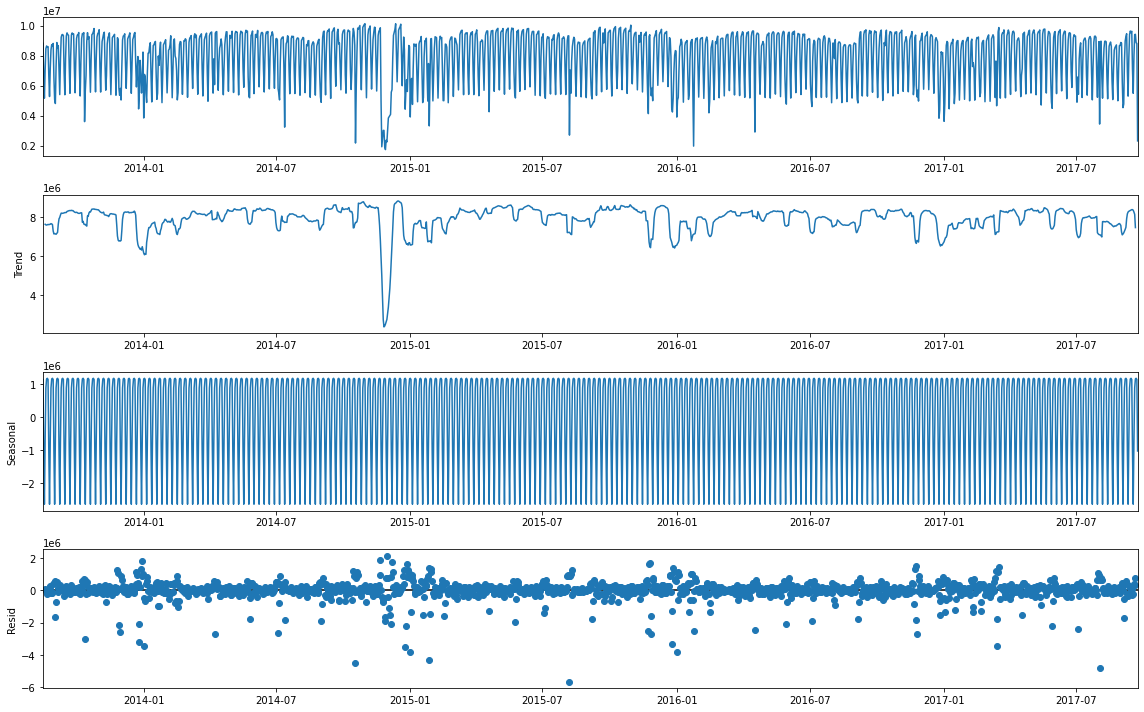

In [23]:
# Decomposing our time series
plt.rc("figure", figsize=(16, 10))
decompose = seasonal_decompose(df_tot[-1500:].set_index('datetime'), period=7, model='additive')
decompose.plot();

The total traffic is a 'well-behaved' time series. The residuals are fairly constant over the time. It means that the additive decomposition do a good job on this data.

**Now let's see the ADF statistic for a set of stations and subway lines.**

In [24]:
h_size = 50

def print_result(df, key, critical_thresh=-2.863):
    print("%18s | ADF Statistic" % (key.capitalize()))
    print("-" * h_size)
    for elem in df[key].unique()[10:20]:
        result = dickey_fuller_test(df[df[key]==elem].traffic, print_results=False)
        mode = 'stationary' if result[0] < critical_thresh else 'non-stationary'
        print('%18s | %.4f, %s' % (elem, result[0], mode))

print("=" * h_size)
print("Dickey-Fuller test | Critical Value: 5% (-2.863)")
print("=" * h_size)
print_result(df_st, 'station')
print("-" * h_size)
print_result(df_ln, 'linename')
print("-" * h_size)

Dickey-Fuller test | Critical Value: 5% (-2.863)
           Station | ADF Statistic
--------------------------------------------------
   116 ST-COLUMBIA | -7.5223, stationary
            121 ST | -1.1103, non-stationary
            125 ST | -6.5313, stationary
            135 ST | -6.8129, stationary
   137 ST CITY COL | -3.3065, stationary
   137 ST-CITY COL | -5.2232, stationary
      138 ST-3 AVE | -5.9113, stationary
    138 ST-GR CONC | -5.7548, stationary
    138/GRAND CONC | -3.4236, stationary
             14 ST | -2.2537, non-stationary
--------------------------------------------------
          Linename | ADF Statistic
--------------------------------------------------
                 2 | -6.6340, stationary
                23 | -5.8817, stationary
              2345 | -6.6988, stationary
          2345ACJZ | -1.1822, non-stationary
         2345BDNQR | -6.5288, stationary
             2345R | -2.6436, non-stationary
             2345S | -4.3520, stationary
             23

As we can see the traffic time series of some stations and lines cannot be considered as stationary because of its high ADF Statistic, it indicates that these series are likely to be more difficult to forecast.

Let's take a look at the plot of theses time series.

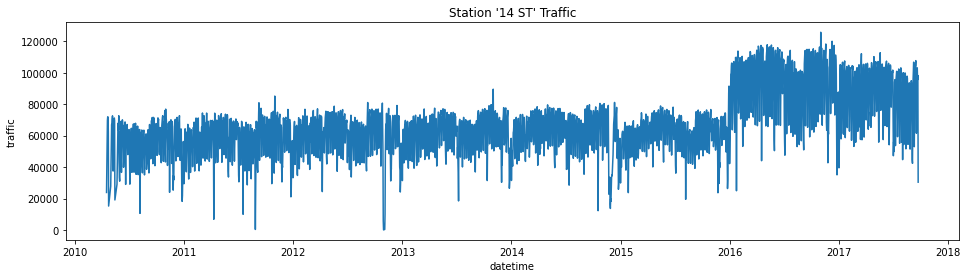

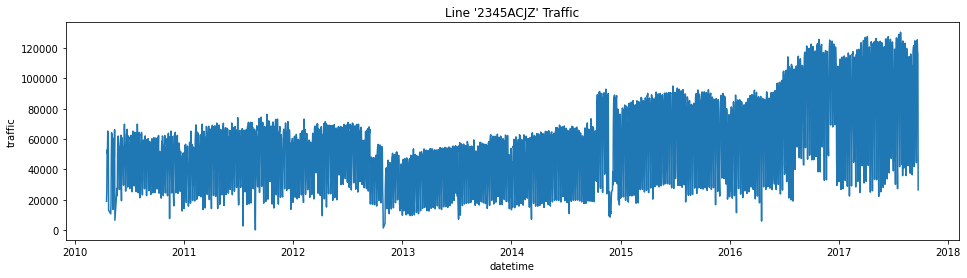

In [25]:
station = '14 ST'
line = '2345ACJZ'

# Plot station traffic
station_traffic = df_st[df_st['station']==station]

plt.figure(figsize=(16, 4))
sns.lineplot(data=station_traffic, x='datetime', y='traffic').set(title="Station \'%s\' Traffic" % (station))
plt.show()

# Plot line traffic
line_traffic = df_ln[df_ln['linename']==line]

plt.figure(figsize=(16, 4))
sns.lineplot(data=line_traffic, x='datetime', y='traffic').set(title="Line \'%s\' Traffic" % (line))
plt.show()

As we can see the station '14 ST' has a sudden increase in traffic in 2016 and shows a downward trend after that.

On the other hand the traffic of the line '2345ACJZ' shows a growth trend since 2013.

OBS: When traffic increases the magnitude of the seasonal component also increases and vice versa. In this case, we must use a multiplicative approach to obtain better forecasting results.

# 5. Final considerations <a class="anchor" id="final-considerations"></a>

As we have seen, the time series analyzed presented a very predictable and stationary behavior in most cases. It means that it's possible to have some predictability about the behavior of this data in the future.

We also noticed that there is a direct relationship between total traffic and the magnitude of the seasonal component. This implies that we must try a multiplicative approach.

The forecasting steps are available in the next notebook.